In [1]:
from ThematicTextClassify.TextClassifier import *
from ThematicTextClassify.Preprocessing import *


/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df =pd.read_csv('Categorized_Links.csv')

# Preprocessing Text Function

In [3]:
# add the title and description column together to form a text document
df['Text'] = df['Title']+ df['Description']
df = df.dropna(subset= ['Text'], axis = 0)

# preprocess the newly defined Text column
df['Processed Text'] = df['Text'].map(preprocess_text)
df['processed_string'] =  [' '.join(text) for text in df['Processed Text']]

In [4]:
df['Class'] = ""
df['Class'] = df.apply(lambda df: 'Supply' if (df['Category'] == 'Supply') else df['Class'], axis =1)
df['Class'] = df.apply(lambda df: 'Other' if (df['Category'] != 'Supply') else df['Class'], axis =1)
df = df.reset_index(drop=True)
df = df.sort_values('Class', ascending  = False)
df = df.reset_index(drop=True)
df = df.drop_duplicates(['Link'],keep= 'first')
df = df.reset_index(drop=True)
len(df)

301

## Create Training and Test data 

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df,
                                                    df['Class'],
                                                    test_size=0.20, 
                                                    random_state=664)
#664

In [6]:
class_test.value_counts()

Other     32
Supply    29
Name: Class, dtype: int64

In [7]:
class_train.value_counts()

Other     150
Supply     90
Name: Class, dtype: int64

# Most Frequent words for Supply

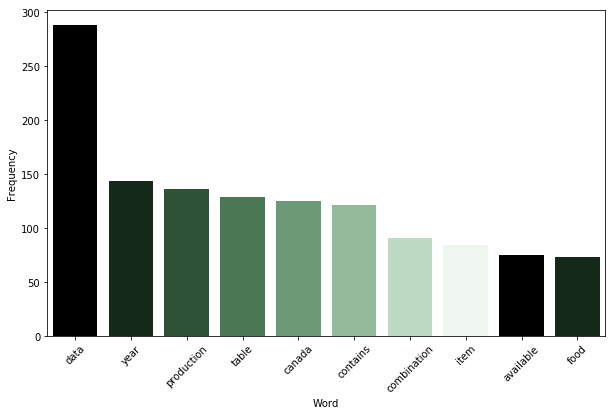

In [8]:
cv = CountVectorizer()
consumption = df[df['Class'] == 'Supply']['processed_string']
bow_consumption = cv.fit_transform(consumption)
freq_consumption = dict(zip(cv.get_feature_names(), np.asarray(bow_consumption.sum(axis=0)).ravel()))
count_consumption = pd.DataFrame(collections.Counter(freq_consumption).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_consumption, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# General Check on Accuracy using CountVectorizer

/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

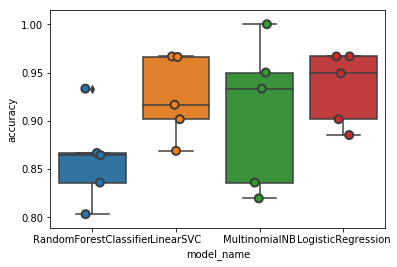

model_name
LinearSVC                 0.923985
LogisticRegression        0.933874
MultinomialNB             0.907814
RandomForestClassifier    0.860750
Name: accuracy, dtype: float64

In [9]:
countvect = CountVectorizer()
features = countvect.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 5000),MultinomialNB(),LogisticRegression(random_state=0)]
cv_df = pd.DataFrame(index=range(5 * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# General Check on Accuracy using tfidf

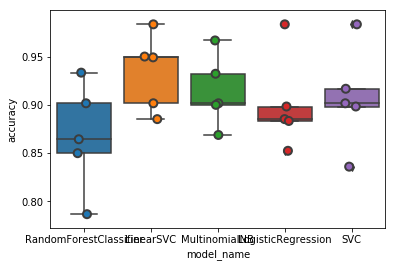

model_name
LinearSVC                 0.933874
LogisticRegression        0.900535
MultinomialNB             0.913872
RandomForestClassifier    0.867253
SVC                       0.907202
Name: accuracy, dtype: float64

In [11]:
tfidf = TfidfVectorizer() 
features = tfidf.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 2000),MultinomialNB(),LogisticRegression(random_state=0), SVC(kernel ='linear', degree = 1, C = 0.25)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# Multinomial Naive Bayes (CountVectorizer)

In [12]:
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
mnb_countvect = grid_vect(mnb, param_mnb, text_train,class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   40.8s finished


done in 40.957s


Best CV score: 0.921
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.97      0.88      0.92        32
      Supply       0.88      0.97      0.92        29

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Accuracy Score:  0.9180327868852459


# Multinomial Naive Bayes (TFIDF)

In [13]:
tfidf = TfidfVectorizer()
mnb_countvect = grid_vect(mnb, param_mnb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=tfidf)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   38.6s finished


done in 38.689s


Best CV score: 0.950
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.94      0.91      0.92        32
      Supply       0.90      0.93      0.92        29

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Accuracy Score:  0.9180327868852459


# Logistic Regression (CountVectorizer)

In [14]:
logreg_countvect = grid_vect(logreg, param_logreg, text_train, class_train, text_test,class_test, parameters_text=param_vect_countvect, vect=countvect)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.3min finished


done in 79.324s


Best CV score: 0.954
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.951


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.94      0.97      0.95        32
      Supply       0.96      0.93      0.95        29

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61

Accuracy Score:  0.9508196721311475


# Logisitc Regression (TFIDF)


In [15]:
logreg_tfidf = grid_vect(logreg, param_logreg, text_train,class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=tfidf)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.2min


done in 77.961s


Best CV score: 0.929
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.89      0.97      0.93        32
      Supply       0.96      0.86      0.91        29

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Accuracy Score:  0.9180327868852459


[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.3min finished


# Linear SVC (CountVectorizer)

In [16]:
linsvc = LinearSVC() 
lscv_countvect = grid_vect(linsvc, param_linearsvc, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect= countvect)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.1min finished


done in 66.381s


Best CV score: 0.950
Best parameters set:
	clf__C: 0.05
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 3)
Cross Validated Test score with best_estimator_: 0.934


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.91      0.97      0.94        32
      Supply       0.96      0.90      0.93        29

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61

Accuracy Score:  0.9344262295081968


# Linear SVC (TFIDF)

In [17]:
linsvc = LinearSVC() 
lscv_tfidf = grid_vect(linsvc, param_linearsvc, text_train,class_train, text_test,class_test, parameters_text=param_vect_countvect, vect=tfidf)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.4s


done in 64.577s


Best CV score: 0.954
Best parameters set:
	clf__C: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.934


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.91      0.97      0.94        32
      Supply       0.96      0.90      0.93        29

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61

Accuracy Score:  0.9344262295081968


[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.1min finished


# Random Forest Classifier (CountVectorizer)

In [18]:
RandF = RandomForestClassifier()
Randomforest_countvect = grid_vect(RandF, param_RandF, text_train,class_train, text_test,class_test, parameters_text=param_vect_countvect, vect=countvect)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 10.3min finished


done in 616.623s


Best CV score: 0.925
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 200
	clf__random_state: 0
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.934


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.91      0.97      0.94        32
      Supply       0.96      0.90      0.93        29

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61

Accuracy Score:  0.9344262295081968


# Random Forest Classifier (TFIDF)

In [20]:
Randomforest_tfidf = grid_vect(RandF, param_RandF, text_train,class_train, text_test,class_test, parameters_text=param_vect_countvect, vect=tfidf)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 19.8min finished


done in 1186.773s


Best CV score: 0.908
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 300
	clf__random_state: 0
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.89      0.97      0.93        32
      Supply       0.96      0.86      0.91        29

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Accuracy Score:  0.9180327868852459


# XGBoost (CountVectorizer)

In [10]:
countvect = CountVectorizer()
xgb = XGBClassifier(random_state=1995,colsample_bytree=0.3, subsample=0.3)
XGboost_tfidf = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 72.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 87.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 105.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 122.1min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 136.0min finished


done in 8165.429s


Best CV score: 0.958
Best parameters set:
	clf__max_depth: 7
	clf__seed: 2
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 3)
Cross Validated Test score with best_estimator_: 0.951


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.94      0.97      0.95        32
      Supply       0.96      0.93      0.95        29

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61

Accuracy Score:  0.9508196721311475


# XGBoost (TFIDF)

In [11]:
tfidf = TfidfVectorizer() 
xgb = XGBClassifier(random_state=1995,colsample_bytree=0.3, subsample=0.3)
XGboost_countvect = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 46.1min finished


done in 2764.722s


Best CV score: 0.954
Best parameters set:
	clf__max_depth: 5
	clf__seed: 2
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.89      0.97      0.93        32
      Supply       0.96      0.86      0.91        29

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Accuracy Score:  0.9180327868852459
